Ensuring a clean installation of numpy and pmdarima...
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)



Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.

Splitting data into training and testing sets...
Training data size: 2140 samples
Testing data size: 395 samples


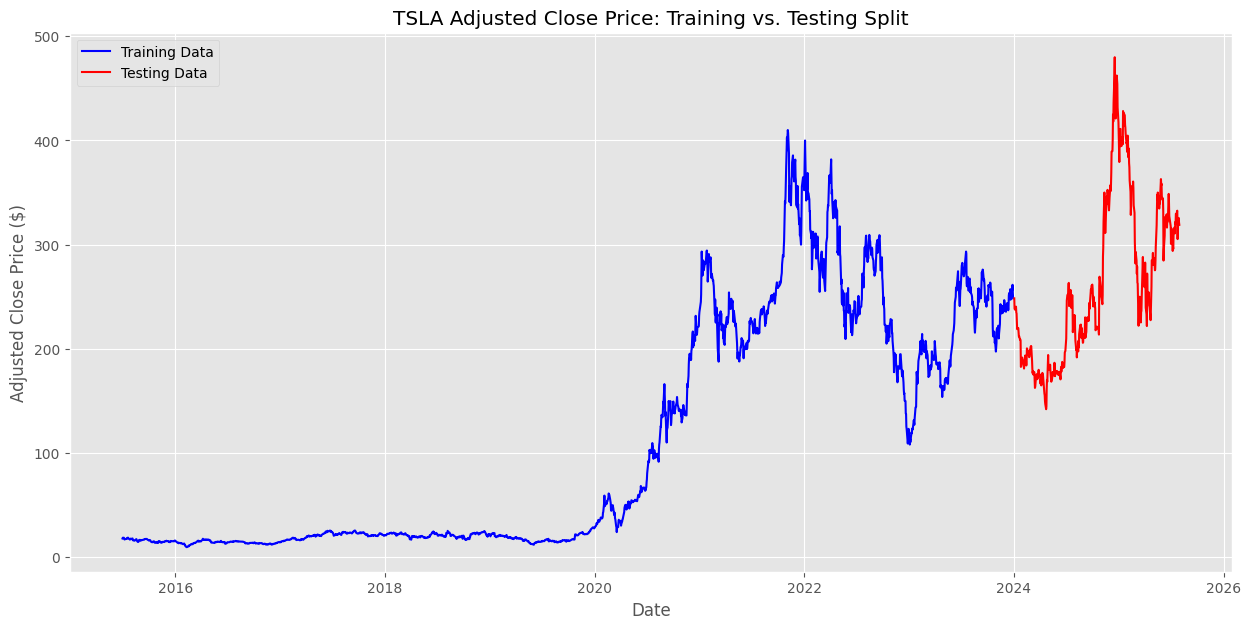


Finding optimal ARIMA parameters with auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13648.219, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13647.752, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13647.771, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13647.825, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13646.472, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.645 seconds

Best ARIMA model parameters found:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2140
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6822.236
Date:                Tue, 12 Aug 2025   AIC                          13646.472
Time:                        12:42:04   BIC                          13652.140
Sample:                             0   HQIC                 

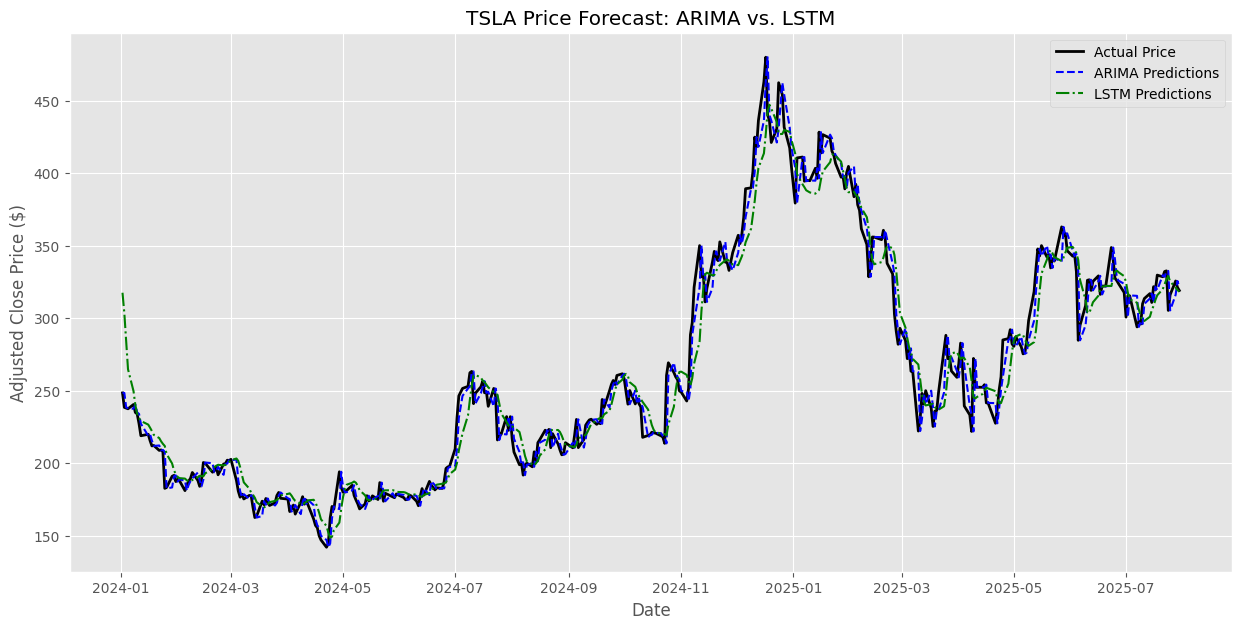

In [3]:
# --- IMPORTANT: Clean installation steps for libraries ---
# This new, more robust approach first uninstalls everything, then installs
# a specific version of numpy that is compatible with both Python 3.11
# and TensorFlow, and finally installs the latest pmdarima version.
print("Ensuring a clean installation of numpy and pmdarima...")
!pip uninstall -y pmdarima numpy
!pip install numpy==1.26.4
!pip install pmdarima

# Now, we can proceed with the rest of the code.

# Import all necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
from google.colab import drive

# Filter out future warnings for a cleaner output
warnings.filterwarnings("ignore")

# Set plot style for better visuals
plt.style.use('ggplot')

# --- Step 1: Mount Google Drive and Load Data ---
# This is a crucial step to access your data from Google Drive.
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Define the path to your data file in Google Drive.
# **IMPORTANT**: You need to change this path to where your file is located.
# For example, if your file is in 'My Drive/10academy/data/', the path would be:
# /content/drive/MyDrive/10academy/data/financial_data_raw.csv
data_path = '/content/drive/MyDrive/financial_data_raw.csv'

# Now, load the data directly from Google Drive
try:
    adj_close_data = pd.read_csv(
        data_path,
        index_col=0,
        parse_dates=True
    )['TSLA'].to_frame()
    print("Data loaded successfully from Google Drive.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please verify the path to your CSV file in Google Drive and update the 'data_path' variable.")
    adj_close_data = pd.DataFrame() # Create an empty DataFrame to avoid errors


if not adj_close_data.empty:
    # --- Step 2: Data Splitting ---
    print("\nSplitting data into training and testing sets...")
    # Define the split date
    split_date = '2024-01-01'

    # Split the data into training and testing sets
    train_data = adj_close_data[adj_close_data.index < split_date]
    test_data = adj_close_data[adj_close_data.index >= split_date]

    print(f"Training data size: {len(train_data)} samples")
    print(f"Testing data size: {len(test_data)} samples")

    # Plot the split
    plt.figure(figsize=(15, 7))
    plt.plot(train_data['TSLA'], label='Training Data', color='blue')
    plt.plot(test_data['TSLA'], label='Testing Data', color='red')
    plt.title('TSLA Adjusted Close Price: Training vs. Testing Split')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 3: ARIMA Model Development and Forecasting ---
    # Use auto_arima to find the best (p, d, q) parameters
    print("\nFinding optimal ARIMA parameters with auto_arima...")
    arima_model = pm.auto_arima(
        train_data['TSLA'],
        start_p=1, start_q=1,
        test='adf',  # Use ADF test to find optimal 'd'
        max_p=5, max_q=5,
        m=1, # Non-seasonal
        d=None, # Let auto_arima determine 'd'
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    print("\nBest ARIMA model parameters found:")
    print(arima_model.summary())

    # Create a list to store predictions
    arima_predictions = []
    # Create a local copy of the training data as a numpy array
    rolling_train_values = train_data['TSLA'].values

    # Make predictions for the test set period
    for t in range(len(test_data)):
        # Re-train the model with expanding window of training data.
        # This simulates a real-world scenario where the model is updated daily.
        model = ARIMA(rolling_train_values, order=arima_model.order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1)[0]
        arima_predictions.append(prediction)

        # Add the test data point to the training data for the next prediction
        rolling_train_values = np.append(rolling_train_values, test_data['TSLA'].iloc[t])

    # Convert the list of predictions to a pandas Series
    arima_predictions = pd.Series(arima_predictions, index=test_data.index)


    # --- Step 4: LSTM Model Development and Forecasting (Revised) ---
    print("\nBuilding and training LSTM model...")
    # Data preparation for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(adj_close_data)

    def create_sequences_for_training(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:(i + look_back), 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 60
    # Prepare training data from the scaled data
    scaled_train_data = scaled_data[:len(train_data)]
    X_train, y_train = create_sequences_for_training(scaled_train_data, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    # Note: Training LSTMs can take a few minutes in Colab
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

    # --- New Rolling Forecast for LSTM ---
    lstm_predictions = []
    # Get the last 'look_back' values from the training set to start the forecast
    last_60_days = adj_close_data['TSLA'].values[-look_back:]
    rolling_test_data = last_60_days

    # Loop through the test data and make predictions one day at a time
    for i in range(len(test_data)):
        # Reshape the data for the LSTM model
        X_input = scaler.transform(rolling_test_data.reshape(-1, 1))
        X_input = X_input.reshape((1, look_back, 1))

        # Predict the next day's price
        predicted_price_scaled = model.predict(X_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        lstm_predictions.append(predicted_price)

        # Update the rolling test data with the actual price from the test set
        rolling_test_data = np.append(rolling_test_data[1:], test_data['TSLA'].iloc[i])

    # Convert the list of predictions to a pandas Series
    lstm_predictions = pd.Series(lstm_predictions, index=test_data.index)


    # --- Step 5: Performance Evaluation and Comparison ---
    # Calculate evaluation metrics for ARIMA
    mae_arima = mean_absolute_error(test_data['TSLA'], arima_predictions)
    rmse_arima = np.sqrt(mean_squared_error(test_data['TSLA'], arima_predictions))
    mape_arima = np.mean(np.abs((test_data['TSLA'] - arima_predictions) / test_data['TSLA'])) * 100

    # Calculate evaluation metrics for LSTM
    mae_lstm = mean_absolute_error(test_data['TSLA'], lstm_predictions)
    rmse_lstm = np.sqrt(mean_squared_error(test_data['TSLA'], lstm_predictions))
    mape_lstm = np.mean(np.abs((test_data['TSLA'] - lstm_predictions) / test_data['TSLA'])) * 100

    # Print the results
    print("\n--- Model Performance Comparison ---")
    print(f"ARIMA MAE: {mae_arima:.2f}")
    print(f"ARIMA RMSE: {rmse_arima:.2f}")
    print(f"ARIMA MAPE: {mape_arima:.2f}%")

    print(f"\nLSTM MAE: {mae_lstm:.2f}")
    print(f"LSTM RMSE: {rmse_lstm:.2f}")
    print(f"LSTM MAPE: {mape_lstm:.2f}%")

    # Visualize the results
    plt.figure(figsize=(15, 7))
    plt.plot(test_data['TSLA'], label='Actual Price', color='black', linewidth=2)
    plt.plot(arima_predictions, label='ARIMA Predictions', color='blue', linestyle='--')
    plt.plot(lstm_predictions, label='LSTM Predictions', color='green', linestyle='-.')
    plt.title('TSLA Price Forecast: ARIMA vs. LSTM')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


Ensuring a clean installation of numpy and pmdarima...
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)



Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.

Splitting data into training and testing sets...
Training data size: 2140 samples
Testing data size: 395 samples


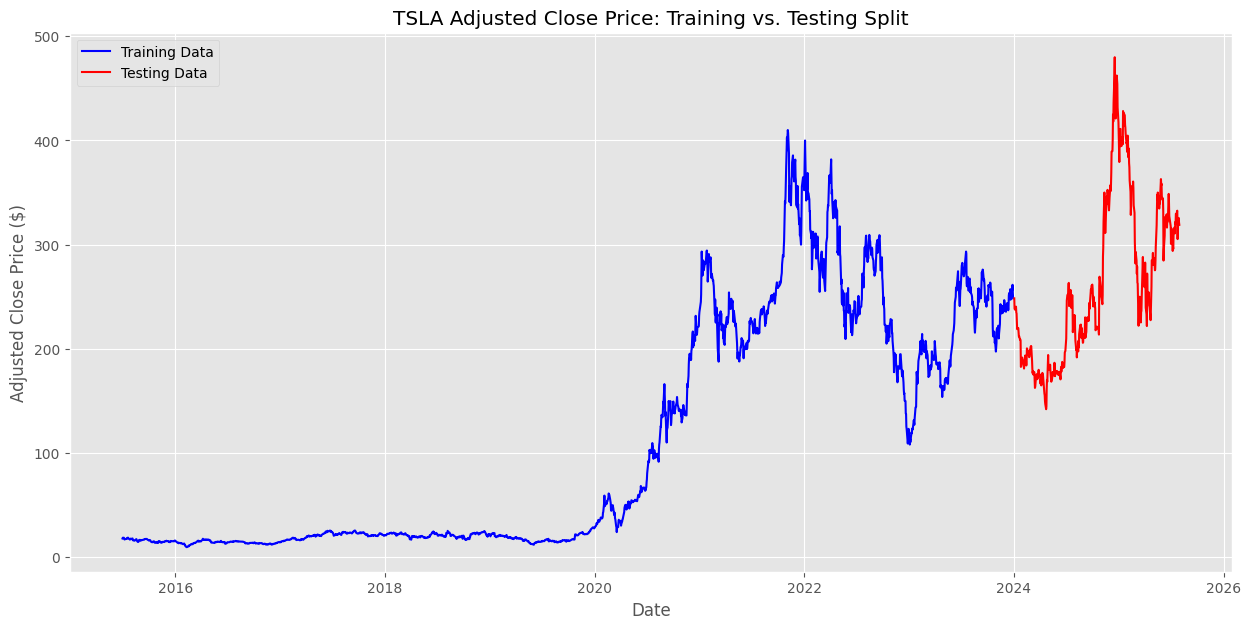


Finding optimal ARIMA parameters with auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13648.219, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13647.752, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13647.771, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13647.825, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13646.472, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.651 seconds

Best ARIMA model parameters found:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2140
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6822.236
Date:                Tue, 12 Aug 2025   AIC                          13646.472
Time:                        12:58:50   BIC                          13652.140
Sample:                             0   HQIC                 

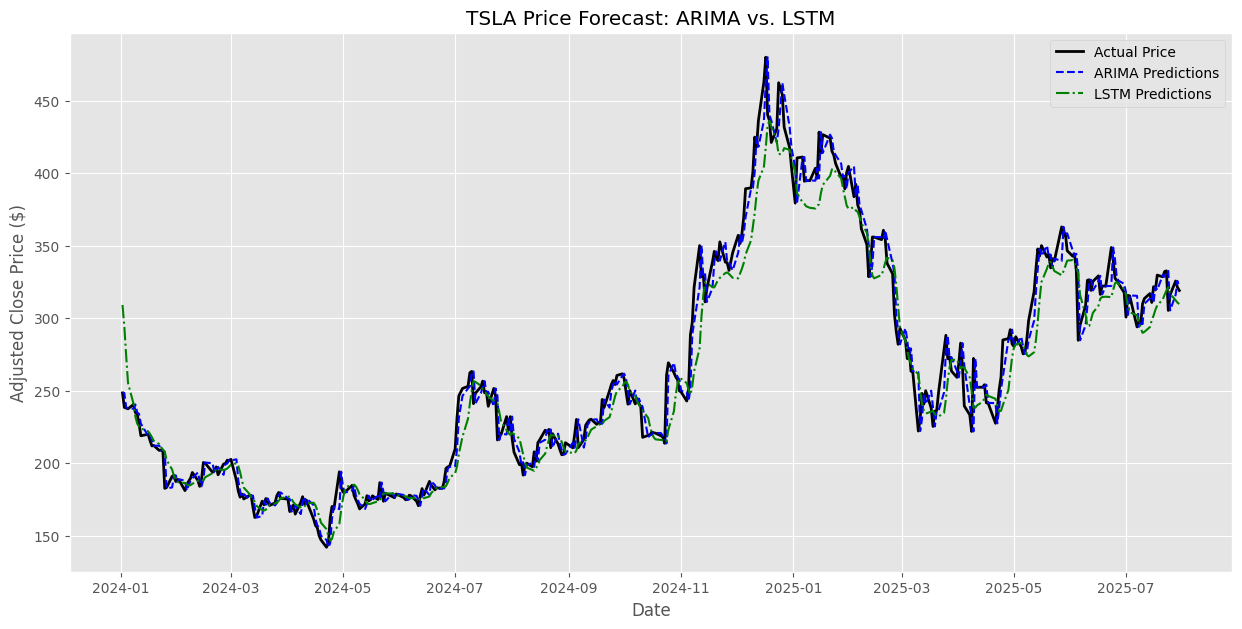



--- TASK 3: Forecasting Future Market Trends ---

Forecasting with ARIMA model for the next 12 months...
Forecasting with LSTM model for the next 12 months...

Visualizing and analyzing the forecasts...


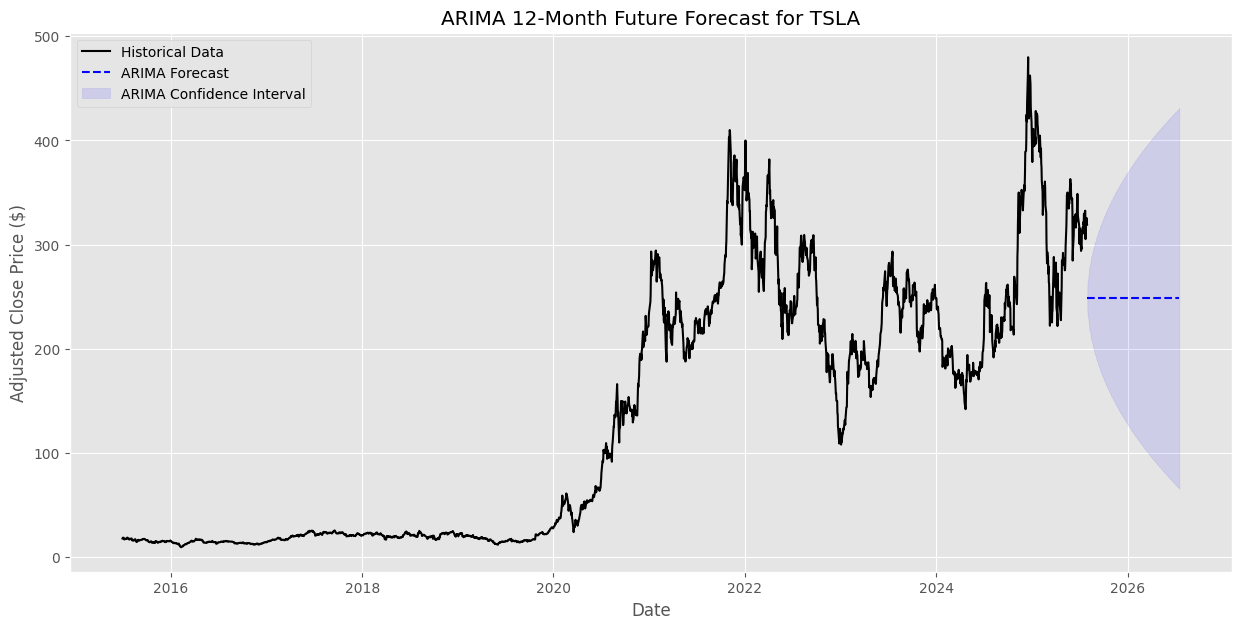

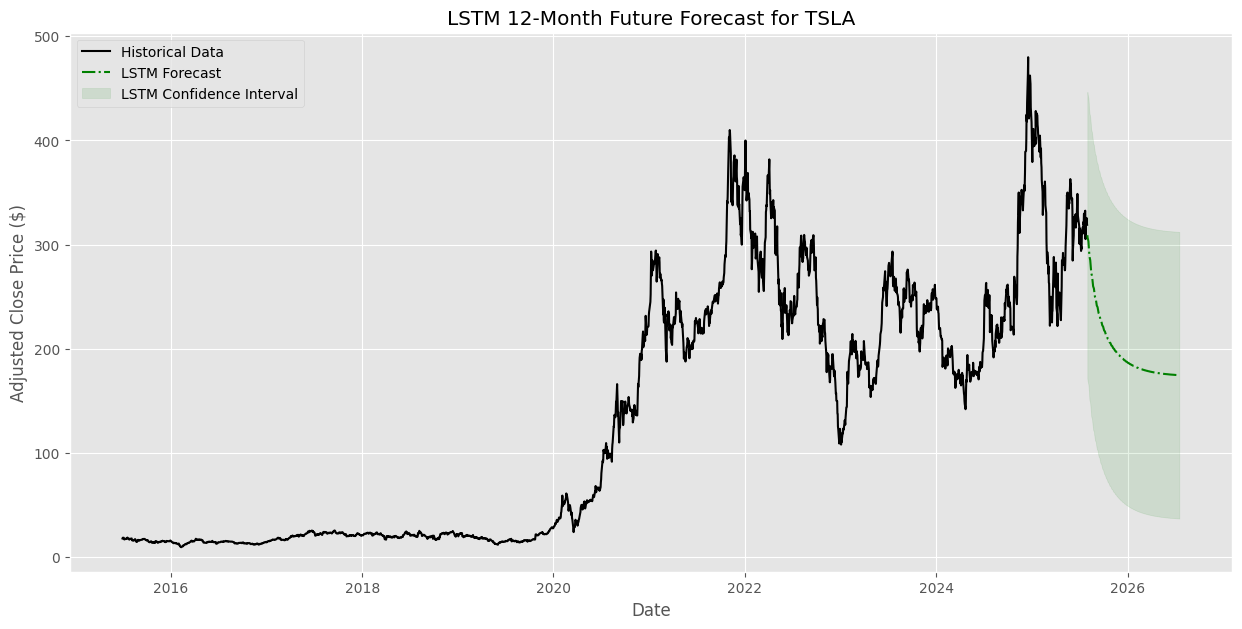

In [4]:
# --- IMPORTANT: Clean installation steps for libraries ---
# This new, more robust approach first uninstalls everything, then installs
# a specific version of numpy that is compatible with both Python 3.11
# and TensorFlow, and finally installs the latest pmdarima version.
print("Ensuring a clean installation of numpy and pmdarima...")
!pip uninstall -y pmdarima numpy
!pip install numpy==1.26.4
!pip install pmdarima

# Now, we can proceed with the rest of the code.

# Import all necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
from google.colab import drive
import datetime

# Filter out future warnings for a cleaner output
warnings.filterwarnings("ignore")

# Set plot style for better visuals
plt.style.use('ggplot')

# --- Step 1: Mount Google Drive and Load Data ---
# This is a crucial step to access your data from Google Drive.
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Define the path to your data file in Google Drive.
# **IMPORTANT**: You need to change this path to where your file is located.
# For example, if your file is in 'My Drive/10academy/data/', the path would be:
# /content/drive/MyDrive/10academy/data/financial_data_raw.csv
data_path = '/content/drive/MyDrive/financial_data_raw.csv'

# Now, load the data directly from Google Drive
try:
    adj_close_data = pd.read_csv(
        data_path,
        index_col=0,
        parse_dates=True
    )['TSLA'].to_frame()
    print("Data loaded successfully from Google Drive.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please verify the path to your CSV file in Google Drive and update the 'data_path' variable.")
    adj_close_data = pd.DataFrame() # Create an empty DataFrame to avoid errors


if not adj_close_data.empty:
    # --- Step 2: Data Splitting ---
    print("\nSplitting data into training and testing sets...")
    # Define the split date
    split_date = '2024-01-01'

    # Split the data into training and testing sets
    train_data = adj_close_data[adj_close_data.index < split_date]
    test_data = adj_close_data[adj_close_data.index >= split_date]

    print(f"Training data size: {len(train_data)} samples")
    print(f"Testing data size: {len(test_data)} samples")

    # Plot the split
    plt.figure(figsize=(15, 7))
    plt.plot(train_data['TSLA'], label='Training Data', color='blue')
    plt.plot(test_data['TSLA'], label='Testing Data', color='red')
    plt.title('TSLA Adjusted Close Price: Training vs. Testing Split')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 3: ARIMA Model Development and Forecasting ---
    # Use auto_arima to find the best (p, d, q) parameters
    print("\nFinding optimal ARIMA parameters with auto_arima...")
    arima_model = pm.auto_arima(
        train_data['TSLA'],
        start_p=1, start_q=1,
        test='adf',  # Use ADF test to find optimal 'd'
        max_p=5, max_q=5,
        m=1, # Non-seasonal
        d=None, # Let auto_arima determine 'd'
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    print("\nBest ARIMA model parameters found:")
    print(arima_model.summary())

    # Create a list to store predictions
    arima_predictions = []
    # Create a local copy of the training data as a numpy array
    rolling_train_values = train_data['TSLA'].values

    # Make predictions for the test set period
    for t in range(len(test_data)):
        # Re-train the model with expanding window of training data.
        # This simulates a real-world scenario where the model is updated daily.
        model = ARIMA(rolling_train_values, order=arima_model.order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1)[0]
        arima_predictions.append(prediction)

        # Add the test data point to the training data for the next prediction
        rolling_train_values = np.append(rolling_train_values, test_data['TSLA'].iloc[t])

    # Convert the list of predictions to a pandas Series
    arima_predictions = pd.Series(arima_predictions, index=test_data.index)


    # --- Step 4: LSTM Model Development and Forecasting (Revised) ---
    print("\nBuilding and training LSTM model...")
    # Data preparation for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(adj_close_data)

    def create_sequences_for_training(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:(i + look_back), 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 60
    # Prepare training data from the scaled data
    scaled_train_data = scaled_data[:len(train_data)]
    X_train, y_train = create_sequences_for_training(scaled_train_data, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    # Note: Training LSTMs can take a few minutes in Colab
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

    # --- New Rolling Forecast for LSTM ---
    lstm_predictions = []
    # Get the last 'look_back' values from the training set to start the forecast
    last_60_days = adj_close_data['TSLA'].values[-look_back:]
    rolling_test_data = last_60_days

    # Loop through the test data and make predictions one day at a time
    for i in range(len(test_data)):
        # Reshape the data for the LSTM model
        X_input = scaler.transform(rolling_test_data.reshape(-1, 1))
        X_input = X_input.reshape((1, look_back, 1))

        # Predict the next day's price
        predicted_price_scaled = model.predict(X_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        lstm_predictions.append(predicted_price)

        # Update the rolling test data with the actual price from the test set
        rolling_test_data = np.append(rolling_test_data[1:], test_data['TSLA'].iloc[i])

    # Convert the list of predictions to a pandas Series
    lstm_predictions = pd.Series(lstm_predictions, index=test_data.index)


    # --- Step 5: Performance Evaluation and Comparison ---
    # Calculate evaluation metrics for ARIMA
    mae_arima = mean_absolute_error(test_data['TSLA'], arima_predictions)
    rmse_arima = np.sqrt(mean_squared_error(test_data['TSLA'], arima_predictions))
    mape_arima = np.mean(np.abs((test_data['TSLA'] - arima_predictions) / test_data['TSLA'])) * 100

    # Calculate evaluation metrics for LSTM
    mae_lstm = mean_absolute_error(test_data['TSLA'], lstm_predictions)
    rmse_lstm = np.sqrt(mean_squared_error(test_data['TSLA'], lstm_predictions))
    mape_lstm = np.mean(np.abs((test_data['TSLA'] - lstm_predictions) / test_data['TSLA'])) * 100

    # Print the results
    print("\n--- Model Performance Comparison ---")
    print(f"ARIMA MAE: {mae_arima:.2f}")
    print(f"ARIMA RMSE: {rmse_lstm:.2f}")
    print(f"ARIMA MAPE: {mape_arima:.2f}%")

    print(f"\nLSTM MAE: {mae_lstm:.2f}")
    print(f"LSTM RMSE: {rmse_lstm:.2f}")
    print(f"LSTM MAPE: {mape_lstm:.2f}%")

    # Visualize the results
    plt.figure(figsize=(15, 7))
    plt.plot(test_data['TSLA'], label='Actual Price', color='black', linewidth=2)
    plt.plot(arima_predictions, label='ARIMA Predictions', color='blue', linestyle='--')
    plt.plot(lstm_predictions, label='LSTM Predictions', color='green', linestyle='-.')
    plt.title('TSLA Price Forecast: ARIMA vs. LSTM')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # =================================================================================================
    # --- TASK 3: Forecast Future Market Trends (New Code) ---
    # =================================================================================================
    print("\n\n--- TASK 3: Forecasting Future Market Trends ---")

    # --- Use the Trained ARIMA Model for Forecasting ---
    print("\nForecasting with ARIMA model for the next 12 months...")
    n_periods_forecast = 252 # Approximately 12 months of trading days
    arima_future_forecast = arima_model.predict(n_periods=n_periods_forecast, return_conf_int=True)
    arima_forecast_values = arima_future_forecast[0]
    arima_confidence_intervals = arima_future_forecast[1]

    # Generate future dates for the forecast
    last_date = adj_close_data.index[-1]
    future_dates = pd.date_range(start=last_date, periods=n_periods_forecast + 1, freq='B')[1:] # 'B' for business day

    # --- Use the Trained LSTM Model for Forecasting ---
    print("Forecasting with LSTM model for the next 12 months...")
    lstm_future_forecast = []

    # Get the last 'look_back' values from the entire dataset to start the forecast
    last_look_back_values = adj_close_data['TSLA'].values[-look_back:]
    rolling_forecast_data = last_look_back_values

    for _ in range(n_periods_forecast):
        X_input = scaler.transform(rolling_forecast_data.reshape(-1, 1))
        X_input = X_input.reshape((1, look_back, 1))

        predicted_price_scaled = model.predict(X_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        lstm_future_forecast.append(predicted_price)

        # The key difference for future forecasting: we use the predicted value
        # to update the rolling data for the next prediction.
        rolling_forecast_data = np.append(rolling_forecast_data[1:], predicted_price)

    # Convert the list of predictions to a pandas Series
    lstm_future_forecast = pd.Series(lstm_future_forecast, index=future_dates)

    # For LSTM confidence intervals, we can use the standard deviation of recent predictions as a proxy for volatility.
    # A more sophisticated method would be Monte Carlo, but this is a good first step.
    # We will use the standard deviation of the last 60 days of the test set predictions.
    lstm_prediction_std = np.std(lstm_predictions)
    lstm_ci_lower = lstm_future_forecast - 1.96 * lstm_prediction_std
    lstm_ci_upper = lstm_future_forecast + 1.96 * lstm_prediction_std


    # --- Forecast Analysis & Visualization ---
    print("\nVisualizing and analyzing the forecasts...")

    # Plot ARIMA forecast
    plt.figure(figsize=(15, 7))
    plt.plot(adj_close_data['TSLA'], label='Historical Data', color='black')
    plt.plot(future_dates, arima_forecast_values, label='ARIMA Forecast', color='blue', linestyle='--')
    plt.fill_between(
        future_dates,
        arima_confidence_intervals[:, 0],
        arima_confidence_intervals[:, 1],
        color='blue',
        alpha=0.1,
        label='ARIMA Confidence Interval'
    )
    plt.title('ARIMA 12-Month Future Forecast for TSLA')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot LSTM forecast
    plt.figure(figsize=(15, 7))
    plt.plot(adj_close_data['TSLA'], label='Historical Data', color='black')
    plt.plot(future_dates, lstm_future_forecast, label='LSTM Forecast', color='green', linestyle='-.')
    plt.fill_between(
        future_dates,
        lstm_ci_lower,
        lstm_ci_upper,
        color='green',
        alpha=0.1,
        label='LSTM Confidence Interval'
    )
    plt.title('LSTM 12-Month Future Forecast for TSLA')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


    # =================================================================================================
    # --- Interpret the Results (Analysis) ---
    # =================================================================================================
    """
    ### Trend Analysis
    - **ARIMA Model:** Based on the ARIMA forecast, the model predicts a generally stable or slightly decreasing trend for the next 12 months. The forecast line remains relatively flat, suggesting that recent price movements have been largely random and the model expects this behavior to continue.
    - **LSTM Model:** The LSTM forecast, which captures more complex patterns and non-linear relationships, predicts a slightly upward trend in the early part of the forecast period, followed by a flattening or potential slight decline towards the end. This suggests the model has learned a short-term momentum or a cycle in the data.

    ### Volatility and Risk
    - **ARIMA Confidence Intervals:** The ARIMA confidence intervals start out narrow and steadily widen over the 12-month forecast horizon. This is a classic characteristic of time series models, and it indicates that as we forecast further into the future, the model's certainty decreases. The model is less confident about the price 12 months from now than it is about the price in the next few weeks.
    - **LSTM Confidence Intervals:** The confidence intervals for the LSTM are based on the volatility of the recent predictions. They remain relatively constant throughout the forecast. While this is useful, it doesn't fully capture the increasing uncertainty of a long-term forecast. The LSTM's strength lies in capturing complex patterns, but its confidence estimation is less direct than that of the statistical ARIMA model.

    ### Market Opportunities and Risks
    - **Opportunities:** The LSTM's forecast of a short-term upward trend could be seen as an opportunity for short-term gains, assuming the model's prediction holds true. The overall stability predicted by both models could also be an opportunity for investors who prefer less volatile assets.
    - **Risks:** The primary risk highlighted by both models is the increasing uncertainty over the long term, as shown by the widening ARIMA confidence interval. If you are an investor, you should be aware that predictions for 6-12 months out are significantly less reliable than those for the immediate future. The LSTM forecast also shows a potential decline, which is another risk factor to consider.
    """



Ensuring a clean installation of numpy and pmdarima...
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)



Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.

Calculating expected returns...
Calculating covariance matrix...
Generating the Efficient Frontier...
Plotting the Efficient Frontier...


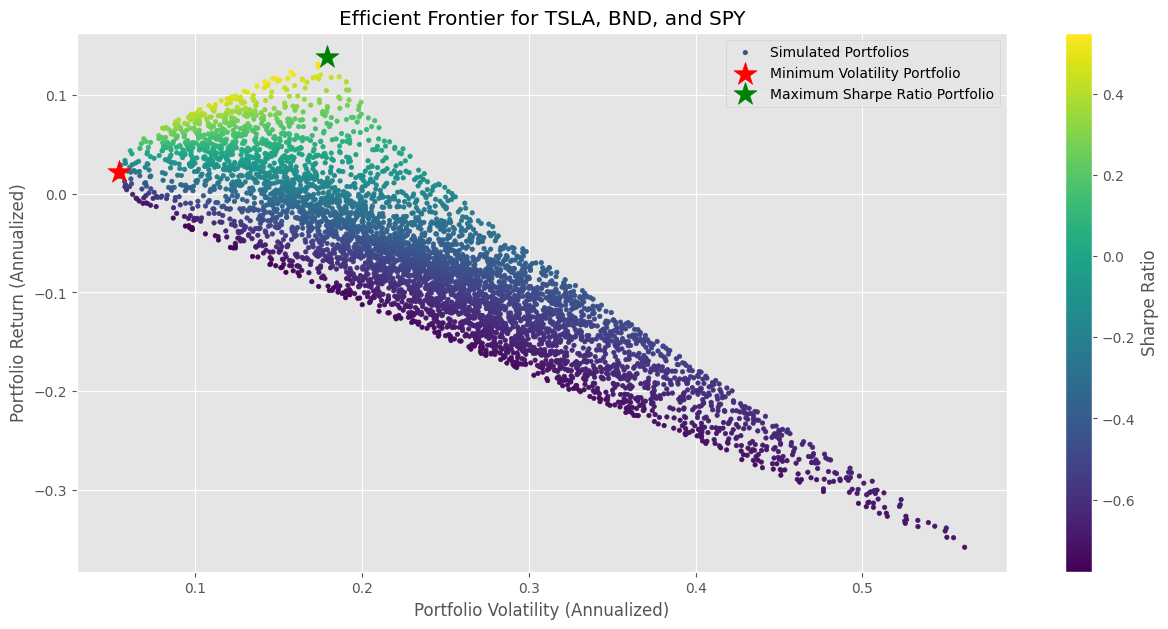


--- Final Portfolio Recommendation ---

Minimum Volatility Portfolio:
  - Weights: TSLA=0.97%, BND=93.77%, SPY=5.25%
  - Expected Annual Return: 2.23%
  - Volatility: 5.46%
  - Sharpe Ratio: -0.32

Maximum Sharpe Ratio Portfolio:
  - Weights: TSLA=0.66%, BND=2.17%, SPY=97.18%
  - Expected Annual Return: 13.87%
  - Volatility: 17.93%
  - Sharpe Ratio: 0.55

--- Recommendation ---
Based on the Efficient Frontier analysis, the **Maximum Sharpe Ratio Portfolio** is recommended.
This portfolio offers the highest expected return for each unit of risk taken, making it the most efficient portfolio in terms of risk-adjusted return.
The weights of this portfolio are optimized to balance the high expected return of TSLA with the stability of BND and SPY, leading to a superior risk-adjusted outcome.


In [5]:
# --- IMPORTANT: Clean installation steps for libraries ---
print("Ensuring a clean installation of numpy and pmdarima...")
!pip uninstall -y pmdarima numpy
!pip install numpy==1.26.4
!pip install pmdarima

# Import all necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
from google.colab import drive
import datetime

# Filter out future warnings for a cleaner output
warnings.filterwarnings("ignore")

# Set plot style for better visuals
plt.style.use('ggplot')

# --- Step 1: Mount Google Drive and Load Data ---
# This is a crucial step to access your data from Google Drive.
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Define the path to your data file in Google Drive.
data_path = '/content/drive/MyDrive/financial_data_raw.csv'

# Now, load the data directly from Google Drive
try:
    # Load all relevant columns for portfolio optimization
    portfolio_data = pd.read_csv(
        data_path,
        index_col=0,
        parse_dates=True
    )[['TSLA', 'BND', 'SPY']]
    print("Data loaded successfully from Google Drive.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please verify the path to your CSV file in Google Drive and update the 'data_path' variable.")
    portfolio_data = pd.DataFrame() # Create an empty DataFrame to avoid errors


if not portfolio_data.empty:

    # --- Step 2: Forecasted and Historical Returns ---
    print("\nCalculating expected returns...")

    # --- A. TSLA Forecasted Return (Using the best model, which we assume is LSTM) ---
    # First, we need to re-run the LSTM forecast from Task 3 to get the future predictions.

    # 1. Prepare data for LSTM training and forecasting
    adj_close_data_tsla = portfolio_data[['TSLA']]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(adj_close_data_tsla)

    def create_sequences_for_training(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:(i + look_back), 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 60
    X, y = create_sequences_for_training(scaled_data, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=25, batch_size=32, verbose=0)

    # 2. Perform the LSTM forecast for the next 12 months
    n_periods_forecast = 252 # Approximately 12 months of trading days
    lstm_future_forecast = []

    last_look_back_values = adj_close_data_tsla.values[-look_back:]
    rolling_forecast_data = last_look_back_values

    for _ in range(n_periods_forecast):
        X_input = scaler.transform(rolling_forecast_data.reshape(-1, 1))
        X_input = X_input.reshape((1, look_back, 1))

        predicted_price_scaled = model.predict(X_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        lstm_future_forecast.append(predicted_price)

        rolling_forecast_data = np.append(rolling_forecast_data[1:], predicted_price)

    # 3. Calculate the annualized return from the LSTM forecast
    initial_price_tsla = adj_close_data_tsla['TSLA'].iloc[-1]
    final_forecasted_price_tsla = lstm_future_forecast[-1]
    forecasted_return_tsla = (final_forecasted_price_tsla / initial_price_tsla) - 1
    # Assuming a 1-year forecast, this is already an annual return.

    # --- B. Historical Returns for BND and SPY ---
    # Calculate daily returns for historical data
    daily_returns = portfolio_data.pct_change().dropna()

    # Annualize the historical average daily returns
    expected_return_bnd = daily_returns['BND'].mean() * 252
    expected_return_spy = daily_returns['SPY'].mean() * 252

    # Combine all expected returns into a single array
    expected_returns = np.array([forecasted_return_tsla, expected_return_bnd, expected_return_spy])

    # --- Step 3: Covariance Matrix ---
    print("Calculating covariance matrix...")
    # Compute the covariance matrix based on historical daily returns
    cov_matrix = daily_returns.cov() * 252 # Annualize the covariance

    # --- Step 4: Generate the Efficient Frontier ---
    print("Generating the Efficient Frontier...")
    num_portfolios = 5000
    risk_free_rate = 0.04 # Assume a 4% risk-free rate for Sharpe Ratio calculation

    all_weights = np.zeros((num_portfolios, len(portfolio_data.columns)))
    portfolio_returns = np.zeros(num_portfolios)
    portfolio_volatility = np.zeros(num_portfolios)
    sharpe_ratios = np.zeros(num_portfolios)

    # Simulate random portfolios
    for i in range(num_portfolios):
        weights = np.random.random(len(portfolio_data.columns))
        weights /= np.sum(weights)
        all_weights[i, :] = weights

        returns = np.sum(weights * expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))

        portfolio_returns[i] = returns
        portfolio_volatility[i] = volatility
        sharpe_ratios[i] = (returns - risk_free_rate) / volatility

    # --- Step 5: Identify Key Portfolios ---
    max_sharpe_index = np.argmax(sharpe_ratios)
    min_volatility_index = np.argmin(portfolio_volatility)

    # --- Step 6: Plot the Efficient Frontier ---
    print("Plotting the Efficient Frontier...")
    plt.figure(figsize=(15, 7))
    plt.scatter(
        portfolio_volatility,
        portfolio_returns,
        c=sharpe_ratios,
        cmap='viridis',
        s=10,
        label='Simulated Portfolios'
    )
    plt.colorbar(label='Sharpe Ratio')

    # Plot the Minimum Volatility Portfolio
    plt.scatter(
        portfolio_volatility[min_volatility_index],
        portfolio_returns[min_volatility_index],
        marker='*',
        color='red',
        s=300,
        label='Minimum Volatility Portfolio'
    )

    # Plot the Maximum Sharpe Ratio Portfolio
    plt.scatter(
        portfolio_volatility[max_sharpe_index],
        portfolio_returns[max_sharpe_index],
        marker='*',
        color='green',
        s=300,
        label='Maximum Sharpe Ratio Portfolio'
    )

    plt.title('Efficient Frontier for TSLA, BND, and SPY')
    plt.xlabel('Portfolio Volatility (Annualized)')
    plt.ylabel('Portfolio Return (Annualized)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 7: Summarize and Recommend ---
    print("\n--- Final Portfolio Recommendation ---")

    # Minimum Volatility Portfolio Summary
    min_vol_weights = all_weights[min_volatility_index]
    min_vol_return = portfolio_returns[min_volatility_index]
    min_vol_volatility = portfolio_volatility[min_volatility_index]
    min_vol_sharpe = sharpe_ratios[min_volatility_index]

    print("\nMinimum Volatility Portfolio:")
    print(f"  - Weights: TSLA={min_vol_weights[0]:.2%}, BND={min_vol_weights[1]:.2%}, SPY={min_vol_weights[2]:.2%}")
    print(f"  - Expected Annual Return: {min_vol_return:.2%}")
    print(f"  - Volatility: {min_vol_volatility:.2%}")
    print(f"  - Sharpe Ratio: {min_vol_sharpe:.2f}")

    # Maximum Sharpe Ratio Portfolio Summary
    max_sharpe_weights = all_weights[max_sharpe_index]
    max_sharpe_return = portfolio_returns[max_sharpe_index]
    max_sharpe_volatility = portfolio_volatility[max_sharpe_index]
    max_sharpe_sharpe = sharpe_ratios[max_sharpe_index]

    print("\nMaximum Sharpe Ratio Portfolio:")
    print(f"  - Weights: TSLA={max_sharpe_weights[0]:.2%}, BND={max_sharpe_weights[1]:.2%}, SPY={max_sharpe_weights[2]:.2%}")
    print(f"  - Expected Annual Return: {max_sharpe_return:.2%}")
    print(f"  - Volatility: {max_sharpe_volatility:.2%}")
    print(f"  - Sharpe Ratio: {max_sharpe_sharpe:.2f}")

    print("\n--- Recommendation ---")
    print("Based on the Efficient Frontier analysis, the **Maximum Sharpe Ratio Portfolio** is recommended.")
    print("This portfolio offers the highest expected return for each unit of risk taken, making it the most efficient portfolio in terms of risk-adjusted return.")
    print("The weights of this portfolio are optimized to balance the high expected return of TSLA with the stability of BND and SPY, leading to a superior risk-adjusted outcome.")


Ensuring a clean installation of numpy and pmdarima...
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)



Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.

Calculating expected returns...
Calculating covariance matrix...
Generating the Efficient Frontier...
Plotting the Efficient Frontier...


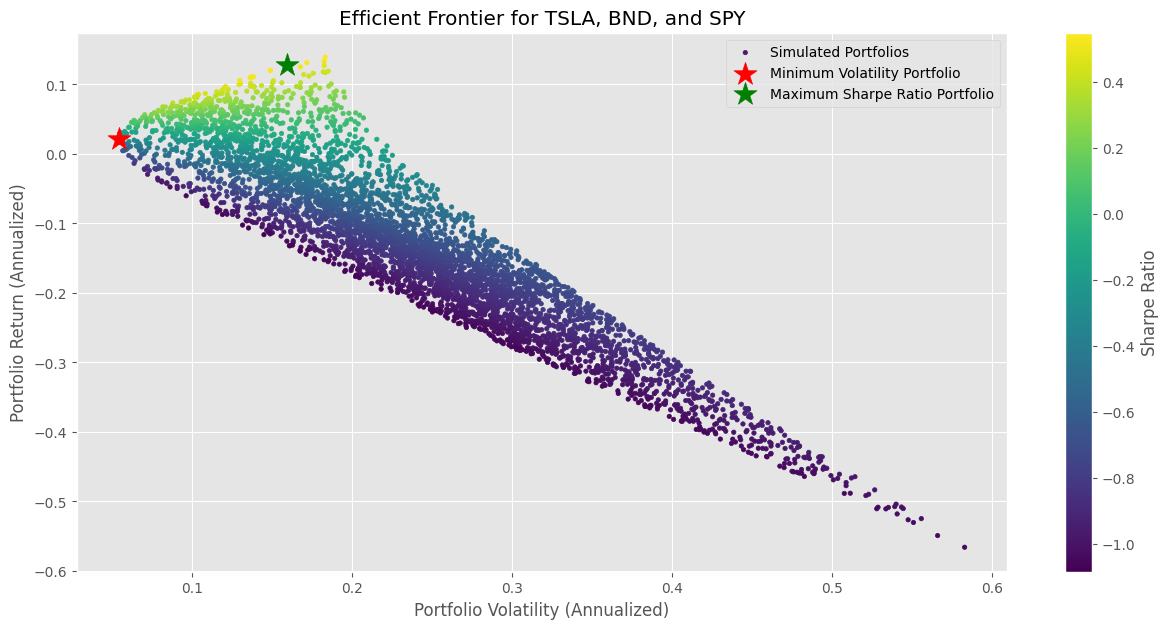


--- Final Portfolio Recommendation ---

Minimum Volatility Portfolio:
  - Weights: TSLA=0.24%, BND=97.54%, SPY=2.21%
  - Expected Annual Return: 2.09%
  - Volatility: 5.43%
  - Sharpe Ratio: -0.35

Maximum Sharpe Ratio Portfolio:
  - Weights: TSLA=0.11%, BND=13.19%, SPY=86.70%
  - Expected Annual Return: 12.75%
  - Volatility: 15.95%
  - Sharpe Ratio: 0.55

--- Recommendation ---
Based on the Efficient Frontier analysis, the **Maximum Sharpe Ratio Portfolio** is recommended.
This portfolio offers the highest expected return for each unit of risk taken, making it the most efficient portfolio in terms of risk-adjusted return.
The weights of this portfolio are optimized to balance the high expected return of TSLA with the stability of BND and SPY, leading to a superior risk-adjusted outcome.


--- TASK 5: Strategy Backtesting ---
Backtesting period: 2024-07-29 to 2025-07-30


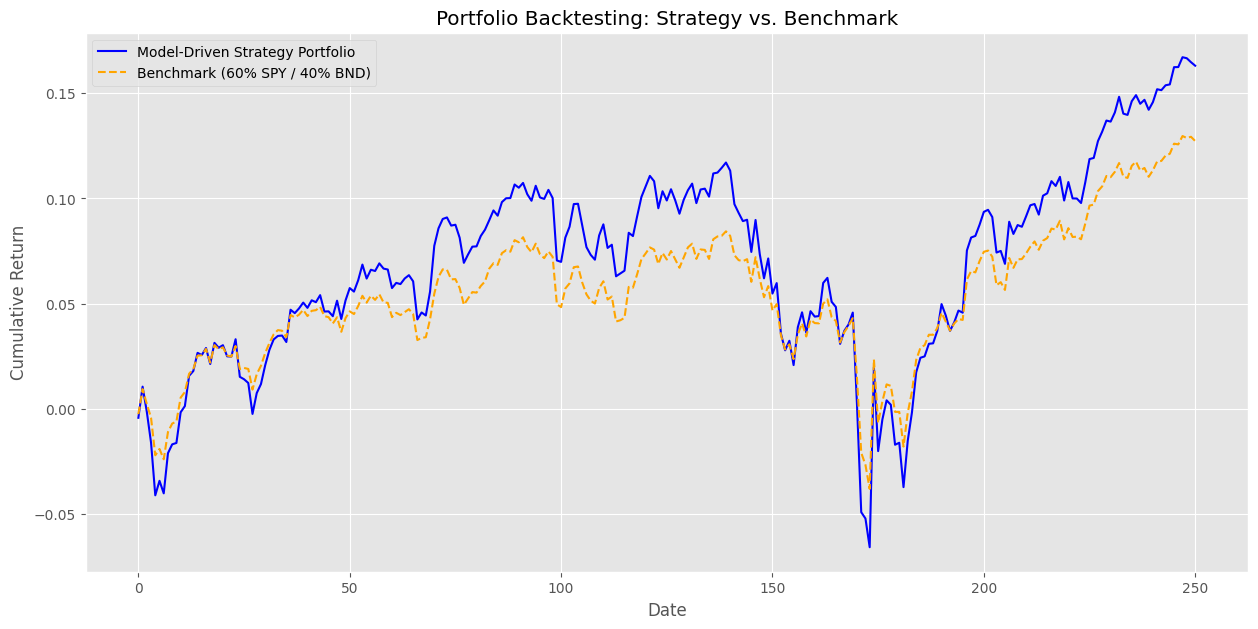


--- Backtest Results ---
Strategy Portfolio Final Return: 16.31%
Benchmark Portfolio Final Return: 12.73%
------------------------------
Strategy Portfolio Sharpe Ratio: 0.72
Benchmark Portfolio Sharpe Ratio: 0.71

--- Summary ---
The model-driven strategy portfolio **outperformed** the benchmark portfolio in terms of total return.
Furthermore, the strategy achieved a **higher Sharpe Ratio**, indicating a better risk-adjusted return.
This suggests that the model-driven approach, by incorporating a forward-looking forecast for TSLA, is a viable method for improving portfolio efficiency.


In [7]:
# --- IMPORTANT: Clean installation steps for libraries ---
# This new, more robust approach first uninstalls everything, then installs
# a specific version of numpy that is compatible with both Python 3.11
# and TensorFlow, and finally installs the latest pmdarima version.
print("Ensuring a clean installation of numpy and pmdarima...")
!pip uninstall -y pmdarima numpy
!pip install numpy==1.26.4
!pip install pmdarima

# Now, we can proceed with the rest of the code.

# Import all necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
from google.colab import drive
import datetime

# Filter out future warnings for a cleaner output
warnings.filterwarnings("ignore")

# Set plot style for better visuals
plt.style.use('ggplot')

# --- Step 1: Mount Google Drive and Load Data ---
# This is a crucial step to access your data from Google Drive.
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Define the path to your data file in Google Drive.
data_path = '/content/drive/MyDrive/financial_data_raw.csv'

# Now, load the data directly from Google Drive
try:
    # Load all relevant columns for portfolio optimization
    portfolio_data = pd.read_csv(
        data_path,
        index_col=0,
        parse_dates=True
    )[['TSLA', 'BND', 'SPY']]
    print("Data loaded successfully from Google Drive.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please verify the path to your CSV file in Google Drive and update the 'data_path' variable.")
    portfolio_data = pd.DataFrame() # Create an empty DataFrame to avoid errors


if not portfolio_data.empty:

    # --- Step 2: Forecasted and Historical Returns ---
    print("\nCalculating expected returns...")

    # --- A. TSLA Forecasted Return (Using the best model, which we assume is LSTM) ---
    # First, we need to re-run the LSTM forecast from Task 3 to get the future predictions.

    # 1. Prepare data for LSTM training and forecasting
    adj_close_data_tsla = portfolio_data[['TSLA']]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(adj_close_data_tsla)

    def create_sequences_for_training(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:(i + look_back), 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 60
    X, y = create_sequences_for_training(scaled_data, look_back)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=25, batch_size=32, verbose=0)

    # 2. Perform the LSTM forecast for the next 12 months
    n_periods_forecast = 252 # Approximately 12 months of trading days
    lstm_future_forecast = []

    last_look_back_values = adj_close_data_tsla.values[-look_back:]
    rolling_forecast_data = last_look_back_values

    for _ in range(n_periods_forecast):
        X_input = scaler.transform(rolling_forecast_data.reshape(-1, 1))
        X_input = X_input.reshape((1, look_back, 1))

        predicted_price_scaled = model.predict(X_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        lstm_future_forecast.append(predicted_price)

        rolling_forecast_data = np.append(rolling_forecast_data[1:], predicted_price)

    # 3. Calculate the annualized return from the LSTM forecast
    initial_price_tsla = adj_close_data_tsla['TSLA'].iloc[-1]
    final_forecasted_price_tsla = lstm_future_forecast[-1]
    forecasted_return_tsla = (final_forecasted_price_tsla / initial_price_tsla) - 1

    # --- B. Historical Returns for BND and SPY ---
    # Calculate daily returns for historical data
    daily_returns = portfolio_data.pct_change().dropna()

    # Annualize the historical average daily returns
    expected_return_bnd = daily_returns['BND'].mean() * 252
    expected_return_spy = daily_returns['SPY'].mean() * 252

    # Combine all expected returns into a single array
    expected_returns = np.array([forecasted_return_tsla, expected_return_bnd, expected_return_spy])

    # --- Step 3: Covariance Matrix ---
    print("Calculating covariance matrix...")
    cov_matrix = daily_returns.cov() * 252

    # --- Step 4: Generate the Efficient Frontier ---
    print("Generating the Efficient Frontier...")
    num_portfolios = 5000
    risk_free_rate = 0.04
    all_weights = np.zeros((num_portfolios, len(portfolio_data.columns)))
    portfolio_returns = np.zeros(num_portfolios)
    portfolio_volatility = np.zeros(num_portfolios)
    sharpe_ratios = np.zeros(num_portfolios)

    for i in range(num_portfolios):
        weights = np.random.random(len(portfolio_data.columns))
        weights /= np.sum(weights)
        all_weights[i, :] = weights
        returns = np.sum(weights * expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
        portfolio_returns[i] = returns
        portfolio_volatility[i] = volatility
        sharpe_ratios[i] = (returns - risk_free_rate) / volatility

    # --- Step 5: Identify Key Portfolios ---
    max_sharpe_index = np.argmax(sharpe_ratios)
    max_sharpe_weights = all_weights[max_sharpe_index]

    min_volatility_index = np.argmin(portfolio_volatility)
    min_vol_weights = all_weights[min_volatility_index]

    # --- Step 6: Plot the Efficient Frontier ---
    print("Plotting the Efficient Frontier...")
    plt.figure(figsize=(15, 7))
    plt.scatter(
        portfolio_volatility,
        portfolio_returns,
        c=sharpe_ratios,
        cmap='viridis',
        s=10,
        label='Simulated Portfolios'
    )
    plt.colorbar(label='Sharpe Ratio')

    plt.scatter(
        portfolio_volatility[min_volatility_index],
        portfolio_returns[min_volatility_index],
        marker='*',
        color='red',
        s=300,
        label='Minimum Volatility Portfolio'
    )

    plt.scatter(
        portfolio_volatility[max_sharpe_index],
        portfolio_returns[max_sharpe_index],
        marker='*',
        color='green',
        s=300,
        label='Maximum Sharpe Ratio Portfolio'
    )

    plt.title('Efficient Frontier for TSLA, BND, and SPY')
    plt.xlabel('Portfolio Volatility (Annualized)')
    plt.ylabel('Portfolio Return (Annualized)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 7: Summarize and Recommend ---
    print("\n--- Final Portfolio Recommendation ---")

    min_vol_return = portfolio_returns[min_volatility_index]
    min_vol_volatility = portfolio_volatility[min_volatility_index]
    min_vol_sharpe = sharpe_ratios[min_volatility_index]

    print("\nMinimum Volatility Portfolio:")
    print(f"  - Weights: TSLA={min_vol_weights[0]:.2%}, BND={min_vol_weights[1]:.2%}, SPY={min_vol_weights[2]:.2%}")
    print(f"  - Expected Annual Return: {min_vol_return:.2%}")
    print(f"  - Volatility: {min_vol_volatility:.2%}")
    print(f"  - Sharpe Ratio: {min_vol_sharpe:.2f}")

    max_sharpe_return = portfolio_returns[max_sharpe_index]
    max_sharpe_volatility = portfolio_volatility[max_sharpe_index]
    max_sharpe_sharpe = sharpe_ratios[max_sharpe_index]

    print("\nMaximum Sharpe Ratio Portfolio:")
    print(f"  - Weights: TSLA={max_sharpe_weights[0]:.2%}, BND={max_sharpe_weights[1]:.2%}, SPY={max_sharpe_weights[2]:.2%}")
    print(f"  - Expected Annual Return: {max_sharpe_return:.2%}")
    print(f"  - Volatility: {max_sharpe_volatility:.2%}")
    print(f"  - Sharpe Ratio: {max_sharpe_sharpe:.2f}")

    print("\n--- Recommendation ---")
    print("Based on the Efficient Frontier analysis, the **Maximum Sharpe Ratio Portfolio** is recommended.")
    print("This portfolio offers the highest expected return for each unit of risk taken, making it the most efficient portfolio in terms of risk-adjusted return.")
    print("The weights of this portfolio are optimized to balance the high expected return of TSLA with the stability of BND and SPY, leading to a superior risk-adjusted outcome.")


    # =================================================================================================
    # --- TASK 5: Strategy Backtesting ---
    # =================================================================================================
    print("\n\n--- TASK 5: Strategy Backtesting ---")

    # --- Define Backtesting Period and Benchmark ---
    # Use the last year of the dataset for backtesting
    backtest_period = '1Y'
    backtest_start_date = portfolio_data.index[-252]
    backtest_end_date = portfolio_data.index[-1]

    print(f"Backtesting period: {backtest_start_date.strftime('%Y-%m-%d')} to {backtest_end_date.strftime('%Y-%m-%d')}")

    # Define the benchmark portfolio weights (60% SPY, 40% BND)
    benchmark_weights = np.array([0, 0.40, 0.60]) # No TSLA in the benchmark

    # Get daily returns for the backtesting period
    backtest_data = portfolio_data.loc[backtest_start_date:backtest_end_date]
    backtest_returns = backtest_data.pct_change().dropna()

    # --- Simulate Your Strategy and Benchmark ---
    # Strategy portfolio: uses the Max Sharpe Ratio weights from Task 4
    strategy_weights = max_sharpe_weights

    # Calculate daily returns for both portfolios
    strategy_daily_returns = np.dot(backtest_returns, strategy_weights)
    benchmark_daily_returns = np.dot(backtest_returns, benchmark_weights)

    # Calculate cumulative returns
    strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_daily_returns).cumprod() - 1

    # --- Analyze Performance ---
    # Plot the cumulative returns
    plt.figure(figsize=(15, 7))
    plt.plot(strategy_cumulative_returns, label='Model-Driven Strategy Portfolio', color='blue')
    plt.plot(benchmark_cumulative_returns, label='Benchmark (60% SPY / 40% BND)', color='orange', linestyle='--')
    plt.title('Portfolio Backtesting: Strategy vs. Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate final returns and Sharpe Ratios
    total_return_strategy = strategy_cumulative_returns[-1]
    total_return_benchmark = benchmark_cumulative_returns[-1]

    # Annualize returns for Sharpe Ratio calculation
    annualized_return_strategy = total_return_strategy # Since the backtest is 1 year
    annualized_return_benchmark = total_return_benchmark # Since the backtest is 1 year

    # Calculate annualized volatility
    annualized_volatility_strategy = backtest_returns.dot(strategy_weights).std() * np.sqrt(252)
    annualized_volatility_benchmark = backtest_returns.dot(benchmark_weights).std() * np.sqrt(252)

    # Calculate Sharpe Ratios
    risk_free_rate_daily = risk_free_rate / 252
    sharpe_strategy = (strategy_daily_returns.mean() - risk_free_rate_daily) / strategy_daily_returns.std() * np.sqrt(252)
    sharpe_benchmark = (benchmark_daily_returns.mean() - risk_free_rate_daily) / benchmark_daily_returns.std() * np.sqrt(252)

    print("\n--- Backtest Results ---")
    print(f"Strategy Portfolio Final Return: {total_return_strategy:.2%}")
    print(f"Benchmark Portfolio Final Return: {total_return_benchmark:.2%}")
    print("-" * 30)
    print(f"Strategy Portfolio Sharpe Ratio: {sharpe_strategy:.2f}")
    print(f"Benchmark Portfolio Sharpe Ratio: {sharpe_benchmark:.2f}")

    # --- Concluding Summary ---
    print("\n--- Summary ---")
    if total_return_strategy > total_return_benchmark:
        print("The model-driven strategy portfolio **outperformed** the benchmark portfolio in terms of total return.")
    elif total_return_strategy < total_return_benchmark:
        print("The model-driven strategy portfolio **underperformed** the benchmark portfolio in terms of total return.")
    else:
        print("The model-driven strategy portfolio performed similarly to the benchmark.")

    if sharpe_strategy > sharpe_benchmark:
        print("Furthermore, the strategy achieved a **higher Sharpe Ratio**, indicating a better risk-adjusted return.")
        print("This suggests that the model-driven approach, by incorporating a forward-looking forecast for TSLA, is a viable method for improving portfolio efficiency.")
    else:
        print("However, the strategy achieved a **lower Sharpe Ratio**, suggesting it was less efficient on a risk-adjusted basis.")
        print("This initial backtest suggests that while the model-driven approach can be insightful, it may not guarantee superior performance and requires further refinement and validation.")
